## **Estimación de prestamos aprobados para clientes**

En el siguiente notebook se analiza y realiza la predicción de prestamos para clientes.

Dataset disponible en: https://github.com/shrikant-temburwar/Loan-Prediction-Dataset/blob/master/test.csv

### **1. Importación de librerias y de los datos**

In [222]:
# importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# herramientas
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# modelos
import lightgbm as lgb
# escalamiento y normalizacion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
# imputers
from sklearn.impute import SimpleImputer
# metricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
# mejoras
from sklearn.model_selection import GridSearchCV

In [223]:
# datos y conversion a dataframe
df = pd.read_csv('train.csv')
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [224]:
# datos y conversion a dataframe
df2 = pd.read_csv('test.csv')
df2.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

### **2. Limpieza de los datos**

En esta sección se busca realizar una limpieza de los datos, como rellenar datos faltantes, igualar tipos de datos y encontrar datos duplicados. El analisis se lleva a cabo en el dataset de train unicamente.

In [225]:
# dataset
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [226]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [227]:
# estadisticas
print("Estadistica descriptiva del dataset")
df.describe()

Estadistica descriptiva del dataset


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [228]:
# tipos de datos
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [229]:
# duplicados
df.duplicated().sum()

0

In [230]:
# duplicados
df2.duplicated().sum()

0

Se analizan los valores unicos de las columnas categoricas.

In [231]:
# extraer las columnas tipo object
object_columns = df.select_dtypes(include=['object'])

# identificar sus valores unicos 
for column in object_columns:
    unique_values = object_columns[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'Loan_ID': ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001027'
 'LP001028' 'LP001029' 'LP001030' 'LP001032' 'LP001034' 'LP001036'
 'LP001038' 'LP001041' 'LP001043' 'LP001046' 'LP001047' 'LP001050'
 'LP001052' 'LP001066' 'LP001068' 'LP001073' 'LP001086' 'LP001087'
 'LP001091' 'LP001095' 'LP001097' 'LP001098' 'LP001100' 'LP001106'
 'LP001109' 'LP001112' 'LP001114' 'LP001116' 'LP001119' 'LP001120'
 'LP001123' 'LP001131' 'LP001136' 'LP001137' 'LP001138' 'LP001144'
 'LP001146' 'LP001151' 'LP001155' 'LP001157' 'LP001164' 'LP001179'
 'LP001186' 'LP001194' 'LP001195' 'LP001197' 'LP001198' 'LP001199'
 'LP001205' 'LP001206' 'LP001207' 'LP001213' 'LP001222' 'LP001225'
 'LP001228' 'LP001233' 'LP001238' 'LP001241' 'LP001243' 'LP001245'
 'LP001248' 'LP001250' 'LP001253' 'LP001255' 'LP001256' 'LP001259'
 'LP001263' 'LP001264' 'LP001265' 'LP001266' 'LP001267' 'LP001273'
 'LP001275' 'LP001279' 'LP001280' 'LP001282

Se observan varios datos que se categorizan como del tipo binario (si o no, graduado o no graduado, femenino o masculino)

Para evitar incosistencias con los datos categoricos, se convierten todos a minusculas.

In [232]:
# convertir a minusculas
for column in object_columns:
    df[column] = df[column].str.lower()
    unique_values = df[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'Loan_ID': ['lp001002' 'lp001003' 'lp001005' 'lp001006' 'lp001008' 'lp001011'
 'lp001013' 'lp001014' 'lp001018' 'lp001020' 'lp001024' 'lp001027'
 'lp001028' 'lp001029' 'lp001030' 'lp001032' 'lp001034' 'lp001036'
 'lp001038' 'lp001041' 'lp001043' 'lp001046' 'lp001047' 'lp001050'
 'lp001052' 'lp001066' 'lp001068' 'lp001073' 'lp001086' 'lp001087'
 'lp001091' 'lp001095' 'lp001097' 'lp001098' 'lp001100' 'lp001106'
 'lp001109' 'lp001112' 'lp001114' 'lp001116' 'lp001119' 'lp001120'
 'lp001123' 'lp001131' 'lp001136' 'lp001137' 'lp001138' 'lp001144'
 'lp001146' 'lp001151' 'lp001155' 'lp001157' 'lp001164' 'lp001179'
 'lp001186' 'lp001194' 'lp001195' 'lp001197' 'lp001198' 'lp001199'
 'lp001205' 'lp001206' 'lp001207' 'lp001213' 'lp001222' 'lp001225'
 'lp001228' 'lp001233' 'lp001238' 'lp001241' 'lp001243' 'lp001245'
 'lp001248' 'lp001250' 'lp001253' 'lp001255' 'lp001256' 'lp001259'
 'lp001263' 'lp001264' 'lp001265' 'lp001266' 'lp001267' 'lp001273'
 'lp001275' 'lp001279' 'lp001280' 'lp001282

In [233]:
# extraer las columnas tipo object del test
object2_columns = df2.select_dtypes(include=['object'])

# convertir a minusculas
for column in object2_columns:
    df2[column] = df2[column].str.lower()
    unique_values = df2[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'Loan_ID': ['lp001015' 'lp001022' 'lp001031' 'lp001035' 'lp001051' 'lp001054'
 'lp001055' 'lp001056' 'lp001059' 'lp001067' 'lp001078' 'lp001082'
 'lp001083' 'lp001094' 'lp001096' 'lp001099' 'lp001105' 'lp001107'
 'lp001108' 'lp001115' 'lp001121' 'lp001124' 'lp001128' 'lp001135'
 'lp001149' 'lp001153' 'lp001163' 'lp001169' 'lp001174' 'lp001176'
 'lp001177' 'lp001183' 'lp001185' 'lp001187' 'lp001190' 'lp001203'
 'lp001208' 'lp001210' 'lp001211' 'lp001219' 'lp001220' 'lp001221'
 'lp001226' 'lp001230' 'lp001231' 'lp001232' 'lp001237' 'lp001242'
 'lp001268' 'lp001270' 'lp001284' 'lp001287' 'lp001291' 'lp001298'
 'lp001312' 'lp001313' 'lp001317' 'lp001321' 'lp001323' 'lp001324'
 'lp001332' 'lp001335' 'lp001338' 'lp001347' 'lp001348' 'lp001351'
 'lp001352' 'lp001358' 'lp001359' 'lp001361' 'lp001366' 'lp001368'
 'lp001375' 'lp001380' 'lp001386' 'lp001400' 'lp001407' 'lp001413'
 'lp001415' 'lp001419' 'lp001420' 'lp001428' 'lp001445' 'lp001446'
 'lp001450' 'lp001452' 'lp001455' 'lp001466

En esta sección se analiza los valores faltantes en las columnas y se buscan métodos para rellenarlos en caso de ser necesario.

In [234]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
Self_Employed,582,32,5.21
LoanAmount,592,22,3.58
Dependents,599,15,2.44
Loan_Amount_Term,600,14,2.28
Gender,601,13,2.12
Married,611,3,0.49
Loan_ID,614,0,0.00
Education,614,0,0.00
ApplicantIncome,614,0,0.00


Valores faltantes en credit_history, self_employed, loanAmount, dependents, loan_amount_term, gender, married.

A continuación se verifica la distribución de los datos en las columnas numéricas.

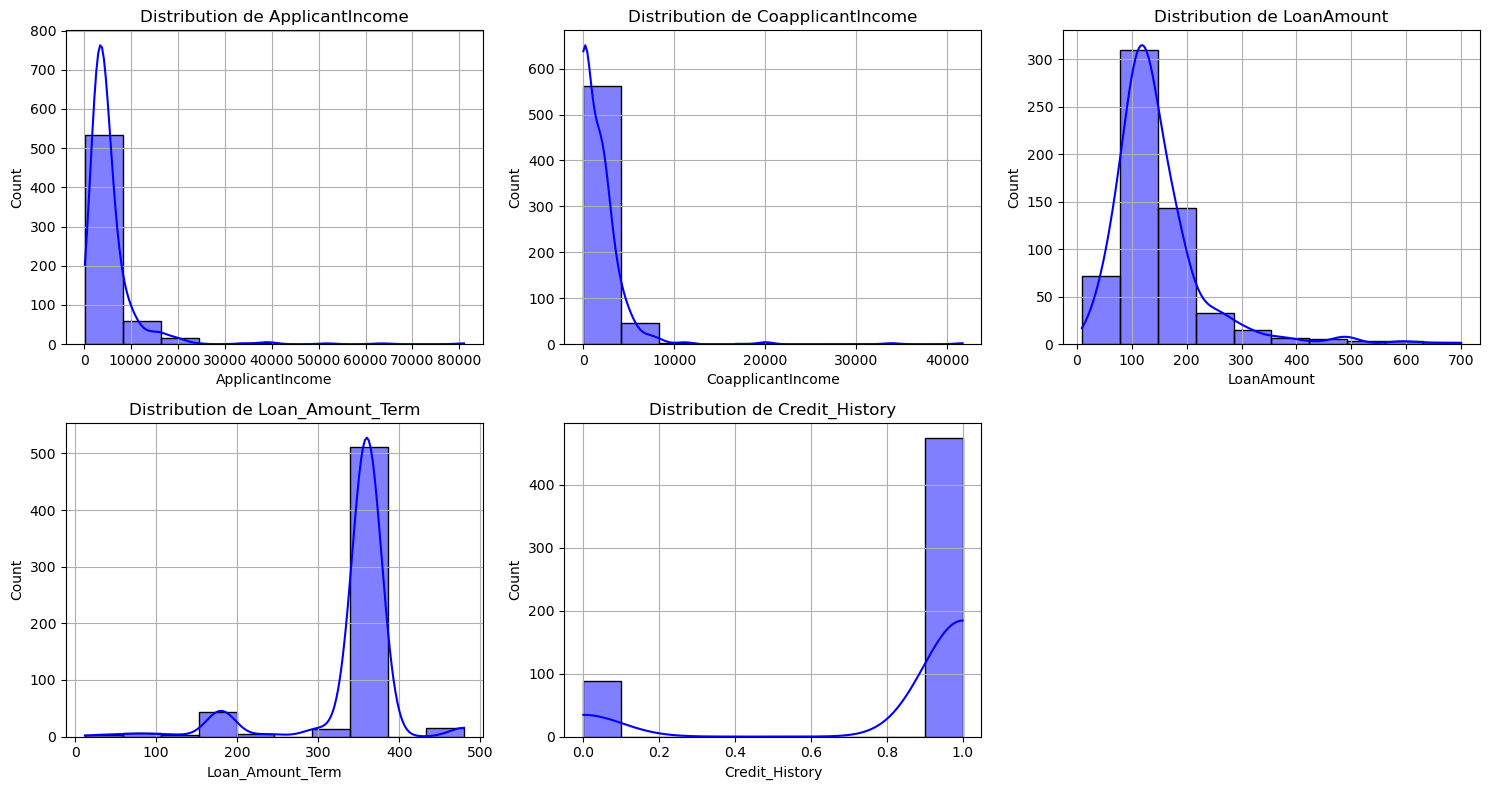

In [235]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# distribucion de los datos
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.histplot(df[col], kde=True, color="blue", bins=10)  
    plt.title(f"Distribution de {col}")
    plt.tight_layout()
    plt.grid()

plt.show()

LoanAmount presenta una distribución normal sesgada.

Luego, se busca identificar outliers en las columnas numéricas.

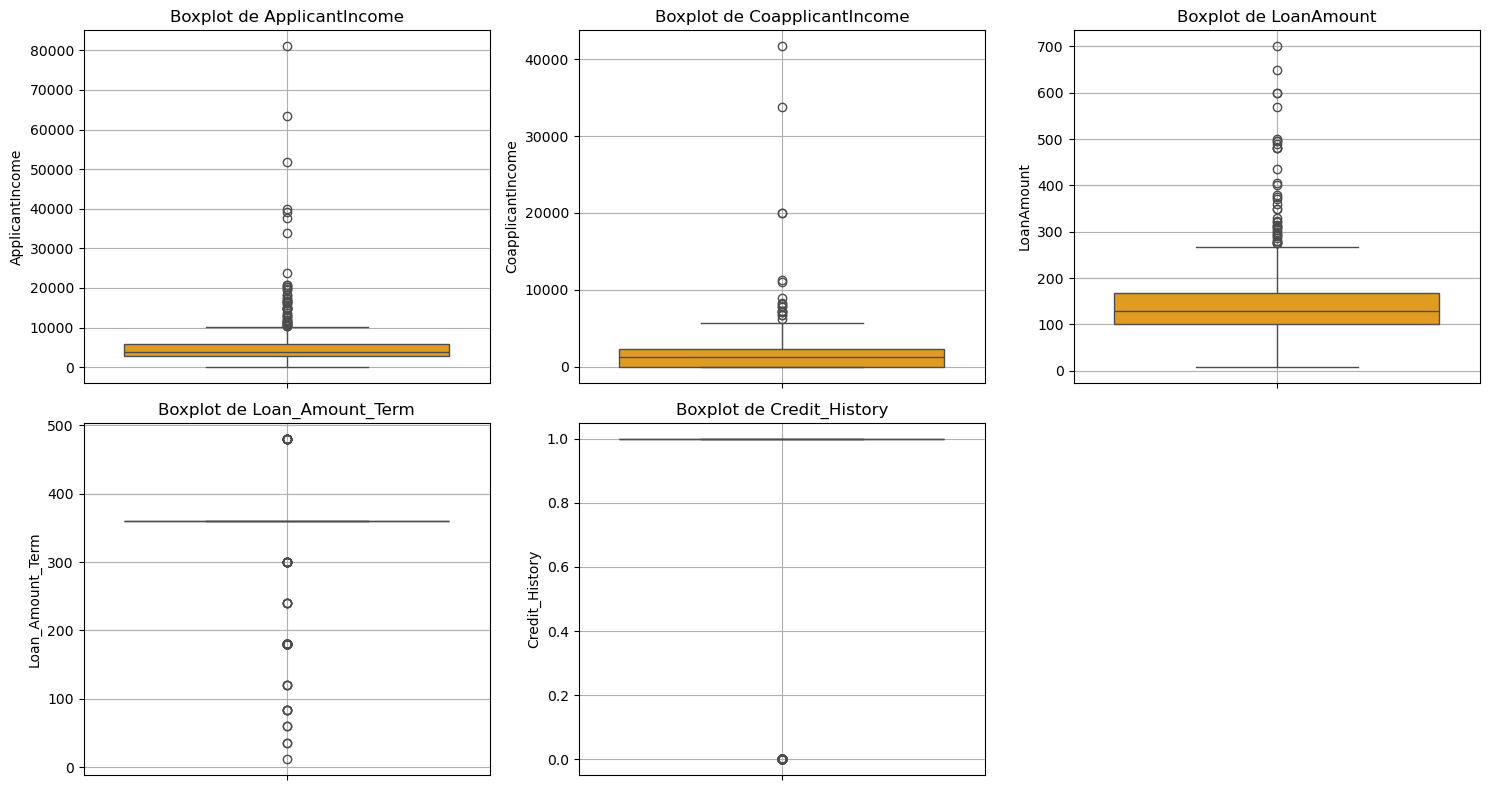

In [236]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.grid()

plt.show()

Se visualizan outliers en el dataset. A fin de comprender los datos que son outliers en las columnas mencionadas se procede a extraer esos datos y determinar su procedencia.

In [237]:
# estadisticas 
print("Estadisticas de ApplicantIncome: \n",df['ApplicantIncome'].describe())
print("Estadisticas de CoapplicantIncome: \n",df['CoapplicantIncome'].describe())
print("Estadisticas de LoanAmount: \n",df['LoanAmount'].describe())
print("Estadisticas de Loan_Amount_Term: \n",df['Loan_Amount_Term'].describe())
print("Estadisticas de Credit_History: \n",df['Credit_History'].describe())

Estadisticas de ApplicantIncome: 
 count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64
Estadisticas de CoapplicantIncome: 
 count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64
Estadisticas de LoanAmount: 
 count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64
Estadisticas de Loan_Amount_Term: 
 count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64
Estadisticas de Credit_History: 
 count    564.0

Los valores faltantes del tipo categorico serán rellenados con la moda.

In [238]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
Self_Employed,582,32,5.21
LoanAmount,592,22,3.58
Dependents,599,15,2.44
Loan_Amount_Term,600,14,2.28
Gender,601,13,2.12
Married,611,3,0.49
Loan_ID,614,0,0.00
Education,614,0,0.00
ApplicantIncome,614,0,0.00


In [239]:
# columnas categoricas 
categorical_columns = df.select_dtypes(include=['object']).columns

# rellenar con la moda
for column in categorical_columns:
    moda = df[column].mode()[0]  
    df[column] = df[column].fillna(moda)

# resultado
print(df[categorical_columns].isnull().sum())

Loan_ID          0
Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
Loan_Status      0
dtype: int64


In [240]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
LoanAmount,592,22,3.58
Loan_Amount_Term,600,14,2.28
Loan_ID,614,0,0.00
Gender,614,0,0.00
Married,614,0,0.00
Dependents,614,0,0.00
Education,614,0,0.00
Self_Employed,614,0,0.00
ApplicantIncome,614,0,0.00


Los datos faltantes de las columnas numericas rellenadas con la mediana.

In [241]:
# columnas numericas
numerical_columns = df.select_dtypes(include=['int64','float64']).columns

# rellenar con la moda
for column in numerical_columns:
    moda = df[column].mode()[0]  
    df[column] = df[column].fillna(moda)

# resultado
print(df[numerical_columns].isnull().sum())

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64


In [242]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Loan_ID,614,0,0.0
Gender,614,0,0.0
Married,614,0,0.0
Dependents,614,0,0.0
Education,614,0,0.0
Self_Employed,614,0,0.0
ApplicantIncome,614,0,0.0
CoapplicantIncome,614,0,0.0
LoanAmount,614,0,0.0
Loan_Amount_Term,614,0,0.0


Se verifan los datos faltantes para el set de test

In [243]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df2.shape[0]-df2.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df2.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df2.isnull().sum(axis=0)/df2.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,338,29,7.90
Self_Employed,344,23,6.27
Gender,356,11,3.00
Dependents,357,10,2.72
Loan_Amount_Term,361,6,1.63
LoanAmount,362,5,1.36
Loan_ID,367,0,0.00
Married,367,0,0.00
Education,367,0,0.00
ApplicantIncome,367,0,0.00


Se procede a aplicar las mismas tecnicas de relleno.

In [244]:
# columnas categoricas 
categorical2_columns = df2.select_dtypes(include=['object']).columns

# rellenar con la moda
for column in categorical2_columns:
    moda = df2[column].mode()[0]  
    df2[column] = df2[column].fillna(moda)

# resultado
print(df2[categorical2_columns].isnull().sum())

Loan_ID          0
Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
dtype: int64


In [245]:
# columnas numericas
numerical2_columns = df2.select_dtypes(include=['int64','float64']).columns

# rellenar con la moda
for column in numerical2_columns:
    moda = df2[column].mode()[0]  
    df2[column] = df2[column].fillna(moda)

# resultado
print(df2[numerical2_columns].isnull().sum())

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64


In [246]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df2.shape[0]-df2.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df2.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df2.isnull().sum(axis=0)/df2.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Loan_ID,367,0,0.0
Gender,367,0,0.0
Married,367,0,0.0
Dependents,367,0,0.0
Education,367,0,0.0
Self_Employed,367,0,0.0
ApplicantIncome,367,0,0.0
CoapplicantIncome,367,0,0.0
LoanAmount,367,0,0.0
Loan_Amount_Term,367,0,0.0


Ambos datasets quedaron limpios.

Por ultimo, las variables que tienen comportamiento binario se convierten a 1 y 0.

Columna 'Gender': ['male' 'female' nan]
Columna 'Married': ['no' 'yes' nan]
Columna 'Dependents': ['0' '1' '2' '3+' nan]
Columna 'Education': ['graduate' 'not graduate']
Columna 'Self_Employed': ['no' 'yes' nan]
Columna 'Property_Area': ['urban' 'rural' 'semiurban']
Columna 'Loan_Status': ['y' 'n']

In [247]:
# categoricas binarias a numericas
df['Gender'] = df['Gender'].map({'male': 1, 'female': 0})
df['Married'] = df['Married'].map({'yes': 1, 'no': 0})
df['Education'] = df['Education'].map({'graduate': 1, 'not graduate': 0})
df['Self_Employed'] = df['Self_Employed'].map({'yes': 1, 'no': 0})
df['Loan_Status'] = df['Loan_Status'].map({'y': 1, 'n': 0})

In [248]:
# tipo
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

Se repite el proceso para las columnas del dataset de test.

In [249]:
# categoricas binarias a numericas
df2['Gender'] = df2['Gender'].map({'male': 1, 'female': 0})
df2['Married'] = df2['Married'].map({'yes': 1, 'no': 0})
df2['Education'] = df2['Education'].map({'graduate': 1, 'not graduate': 0})
df2['Self_Employed'] = df2['Self_Employed'].map({'yes': 1, 'no': 0})

In [250]:
# tipo
df2.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

In [251]:
#df
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,lp001002,1,0,0,1,0,5849,0.0,120.0,360.0,1.0,urban,1
1,lp001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,rural,0
2,lp001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,urban,1
3,lp001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,urban,1
4,lp001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,urban,1
5,lp001011,1,1,2,1,1,5417,4196.0,267.0,360.0,1.0,urban,1
6,lp001013,1,1,0,0,0,2333,1516.0,95.0,360.0,1.0,urban,1
7,lp001014,1,1,3+,1,0,3036,2504.0,158.0,360.0,0.0,semiurban,0
8,lp001018,1,1,2,1,0,4006,1526.0,168.0,360.0,1.0,urban,1
9,lp001020,1,1,1,1,0,12841,10968.0,349.0,360.0,1.0,semiurban,0


In [252]:
# df2
df2.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,lp001015,1,1,0,1,0,5720,0,110.0,360.0,1.0,urban
1,lp001022,1,1,1,1,0,3076,1500,126.0,360.0,1.0,urban
2,lp001031,1,1,2,1,0,5000,1800,208.0,360.0,1.0,urban
3,lp001035,1,1,2,1,0,2340,2546,100.0,360.0,1.0,urban
4,lp001051,1,0,0,0,0,3276,0,78.0,360.0,1.0,urban
5,lp001054,1,1,0,0,1,2165,3422,152.0,360.0,1.0,urban
6,lp001055,0,0,1,0,0,2226,0,59.0,360.0,1.0,semiurban
7,lp001056,1,1,2,0,0,3881,0,147.0,360.0,0.0,rural
8,lp001059,1,1,2,1,0,13633,0,280.0,240.0,1.0,urban
9,lp001067,1,0,0,0,0,2400,2400,123.0,360.0,1.0,semiurban


Se procede a visualizar un mapa de calor de las variables.

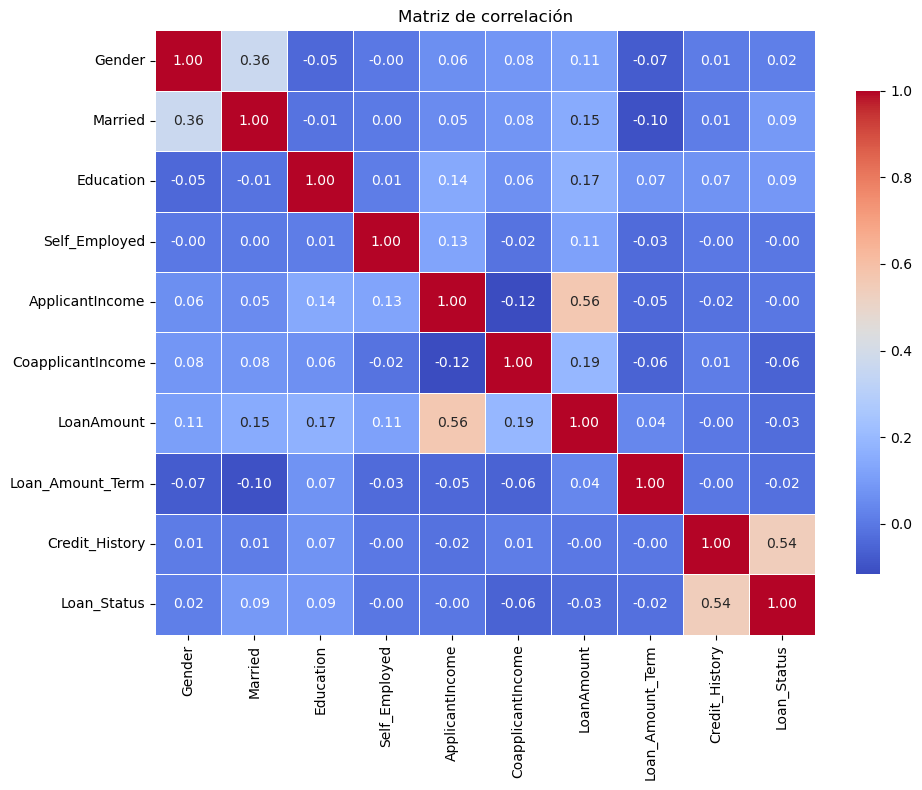

In [253]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int64','float64'])

# matriz de correlación
correlation_matrix = numerical_columns.corr()

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})
plt.title('Matriz de correlación')

# mostrar el grafico
plt.tight_layout()
plt.show()

Se observan correlaciones entre las variables, por ejemplo, loanamount con applicant income, credit history con loan status.

### **3. Preprocesamiento de los datos**

El objetivo de aplicar modelos a este set de datos es el de predecir si la persona puede pedir un prestamo y ser aceptado en base a sus condiciones economicas.

Se realiza el preprocesamiento de los datos para luego ser utilizados en modelos.

In [254]:
#df
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [255]:
# df
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,lp001002,1,0,0,1,0,5849,0.0,120.0,360.0,1.0,urban,1
1,lp001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,rural,0
2,lp001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,urban,1
3,lp001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,urban,1
4,lp001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,urban,1


Se eligen como variable target a loan_status, una variable que determina si se aprobo o no el prestamo. Las variables predictoras seran todas las restantes excepto el loan id, ya que esta variable es un identificador de la persona nada mas. 

In [256]:
# variables categoricas y target
x = df.drop(columns=['Loan_ID','Loan_Status'])  
y = df[['Loan_Status']]

In [257]:
# verificacion 
print("Variables predictoras dimensiones en train" , x.shape)
print("Variable target dimensiones en train" , y.shape)

Variables predictoras dimensiones en train (614, 11)
Variable target dimensiones en train (614, 1)


In [258]:
# extraer columnas
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features =x.select_dtypes(include=['object']).columns

# verificar
print("Features numericas: ", numerical_features)
print("Features categoricas: ", categorical_features)

Features numericas:  Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')
Features categoricas:  Index(['Dependents', 'Property_Area'], dtype='object')


In [259]:
# transformadores para cada subconjunto de columnas
# numerico
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorico
categoric_transformer =  Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [260]:
# crear columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),  
        ('cat', categoric_transformer, categorical_features)  
    ]
)

El dataset viene dividido en train.csv y test.csv, sin embargo, test.csv no tiene la columna loan_status, que es la variable target, por tanto no se utilizara para hacer los test, ya que no se conocen las respuesta. Por eso, se decide realizar el split de esta forma: 

In [261]:
# split del dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### **4. Aplicación de modelos**

### **Modelo LightGBM**

Para predecir si una persona tendra el prestamo aprobado o no, se utiliza el modelo lightgbm

In [262]:
# pipeline 
model_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('classifier', lgb.LGBMClassifier(random_state=42))  
])

In [263]:
# ajustar a los datos de entrenamiento
model_lgbm.fit(x_train, y_train.values.flatten())

[LightGBM] [Info] Number of positive: 302, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703963 -> initscore=0.866240
[LightGBM] [Info] Start training from score 0.866240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Dependents', 'Property_Area'], dtype='object'))])),
                ('classifier', LGBMClassifier(random_state=42))])

In [264]:
# realizar predicciones
y_pred = model_lgbm.predict(x_test)

In [265]:
# evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

Exactitud: 0.7621621621621621
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.48      0.58        65
           1       0.76      0.92      0.83       120

    accuracy                           0.76       185
   macro avg       0.76      0.70      0.71       185
weighted avg       0.76      0.76      0.75       185



In [266]:
# matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

Matriz de Confusión:
[[ 31  34]
 [ 10 110]]


In [267]:
# funcion para graficar la matriz de confusion
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.show()

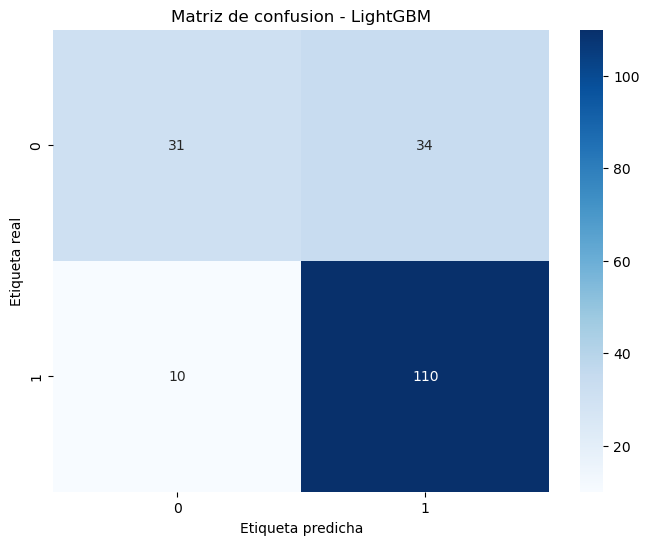

In [268]:
# extraer las clases
classes = np.sort(np.unique(y_test))

# graficar la matriz
plot_confusion_matrix(conf_matrix, classes, title="Matriz de confusion - LightGBM")

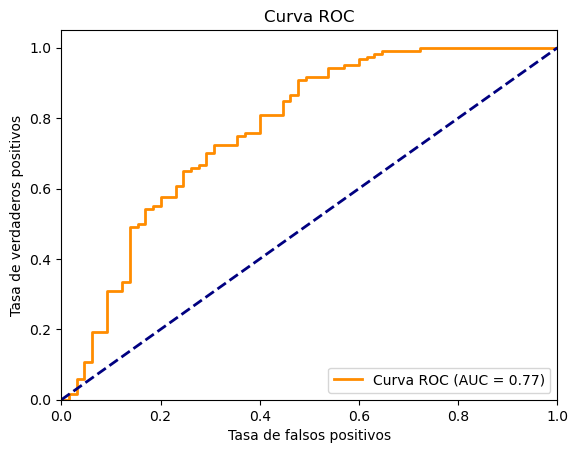

In [269]:
# curva roc 
fpr, tpr, thresholds = roc_curve(y_test, model_lgbm.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

En lineas generales, el modelo realiza buenas predicciones, sin embargo, se va buscar mejorar su rendimiento utilizando gridsearchcv

In [270]:
# hiperparametros a probar
param_grid = {
    'classifier__num_leaves': [30, 50, 100],  
    'classifier__max_depth': [5, 10, 20], 
    'classifier__learning_rate': [0.01, 0.05, 0.1], 
    'classifier__n_estimators': [50, 100, 200],
}

In [271]:
# GridSearchCV
grid_search = GridSearchCV(
    model_lgbm, 
    param_grid,  
    cv=5,  
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1  
)

In [272]:
# buscar en train
grid_search.fit(x_train, y_train.values.flatten())

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 302, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703963 -> initscore=0.866240
[LightGBM] [Info] Start training from score 0.866240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')),
                                                                        (...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Dependents', 'Property_Area'], dtype='object'))])),
                                       ('classifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1],
                         'classifier__max_depth': [5, 10, 20],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__num_leaves': [30, 50, 100]},
             scoring='accuracy', verbose=1)

In [273]:
# resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R² en validación cruzada:", grid_search.best_score_)

Mejores parámetros: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__num_leaves': 30}
Mejor R² en validación cruzada: 0.8204651162790698


In [274]:
# modelo ajustado
best_lgbm_model = grid_search.best_estimator_

In [275]:
# realizar predicciones
y_pred = best_lgbm_model.predict(x_test)

In [276]:
# evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

Exactitud: 0.7837837837837838
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.42      0.57        65
           1       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



In [277]:
# matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

Matriz de Confusión:
[[ 27  38]
 [  2 118]]


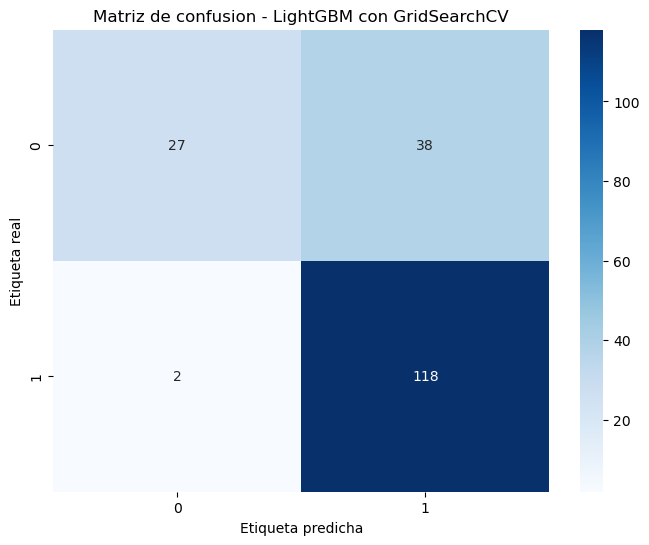

In [278]:
# extraer las clases
classes = np.sort(np.unique(y_test))

# graficar la matriz
plot_confusion_matrix(conf_matrix, classes, title="Matriz de confusion - LightGBM con GridSearchCV")

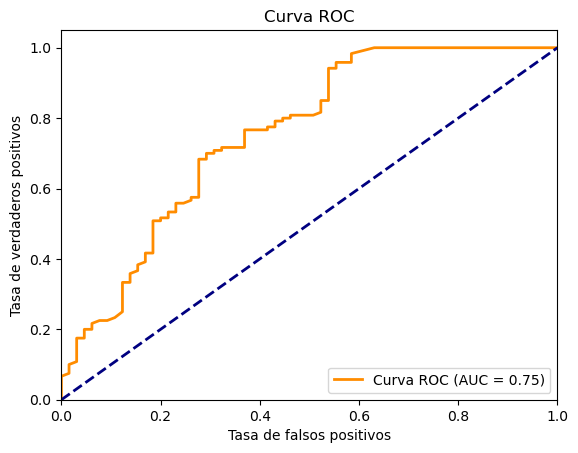

In [279]:
# curva roc 
fpr, tpr, thresholds = roc_curve(y_test, best_lgbm_model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()